In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import glob
import os



In [2]:
folder_path = "../backend/app/data/Trace/"  # Dossier contenant les fichiers CSV
df = pd.read_csv(os.path.join(folder_path, "data_tracesV2-P1.csv"))  # Lire le CSV

In [3]:
df = df.dropna(subset=['Latence'])

column_rename = {"Moment du ping": "Moment_du_ping" ,
                     "throuput": "Throuput" }
df.rename(columns=column_rename, inplace=True)

In [4]:
print("Valeurs uniques avant conversion :")
print(df['Moment_du_ping'].astype(str).str[-10:].value_counts().head(10))  # Voir les suffixes des valeurs

# Conversion des dates avec gestion des erreurs
df['Moment_du_ping'] = pd.to_datetime(df['Moment_du_ping'], errors='coerce')

# Vérifier s'il y a des NaT (valeurs non converties)
if df['Moment_du_ping'].isna().sum() > 0:
    print(f"Nombre de valeurs non converties : {df['Moment_du_ping'].isna().sum()}")
    print("Exemples de valeurs problématiques :")
    print(df[df['Moment_du_ping'].isna()]['Moment_du_ping'].head(10))

# Supprimer les lignes avec des dates invalides
df = df.dropna(subset=['Moment_du_ping'])

# Extraction des caractéristiques temporelles
df['Heure'] = df['Moment_du_ping'].dt.hour
df['Jour'] = df['Moment_du_ping'].dt.dayofweek

# Vérification finale
print(df[['Moment_du_ping', 'Heure', 'Jour']].head())

Valeurs uniques avant conversion :
Moment_du_ping
1 15:17:00    17
1 15:16:00    16
1 15:35:00    14
2 19:11:00    12
2 18:56:00    12
2 18:53:00    11
2 18:51:00     8
1 15:10:00     7
1 15:22:00     7
1 15:18:00     6
Name: count, dtype: int64
Nombre de valeurs non converties : 940
Exemples de valeurs problématiques :
1104   NaT
1105   NaT
1106   NaT
1107   NaT
1108   NaT
1109   NaT
1110   NaT
1111   NaT
1112   NaT
1113   NaT
Name: Moment_du_ping, dtype: datetime64[ns]
       Moment_du_ping  Heure  Jour
0 2024-10-17 13:47:45     13     3
1 2024-10-17 13:47:49     13     3
2 2024-10-17 13:47:53     13     3
3 2024-10-17 13:47:57     13     3
4 2024-10-17 13:48:01     13     3


In [5]:
# Conversion des dates en format datetime
df['Moment_du_ping'] = pd.to_datetime(df['Moment_du_ping'])

# Extraction des caractéristiques temporelles
df['Heure'] = df['Moment_du_ping'].dt.hour
df['Jour'] = df['Moment_du_ping'].dt.dayofweek  # 0 = Lundi, 6 = Dimanche

# Encodage de la ville en numérique
label_encoder = LabelEncoder()
df['Ville_Code'] = label_encoder.fit_transform(df['Ville'])

In [6]:
print(df.head(-5))

      NumTrace  Num_Test    ID_user     Date_Performance  Latence  \
0            1       163  Andrea B.  2024-10-17 13:47:38   203.90   
1            1       164  Andrea B.  2024-10-17 13:47:38   203.37   
2            1       165  Andrea B.  2024-10-17 13:47:38   204.74   
3            1       166  Andrea B.  2024-10-17 13:47:38   116.04   
4            1       167  Andrea B.  2024-10-17 13:47:38   125.04   
...        ...       ...        ...                  ...      ...   
1094         8        81      AMOUR  2024-10-22 19:17:00   284.87   
1095         8        82      AMOUR  2024-10-22 19:17:00   385.05   
1096         8        83      AMOUR  2024-10-22 19:17:00   279.14   
1097         8        84      AMOUR  2024-10-22 19:17:00   280.91   
1098         8        85      AMOUR  2024-10-22 19:18:00   291.32   

      Port_source  Jitter  Port_destination      Ville              Output  \
0           60865    0.00           22124.0  Msambweni           Headphone   
1           623

In [15]:
# Sélection des features pour le clustering
features = ['Latence', 'Jitter', 'Heure', 'Jour', 'Ville_Code']
X = df[features]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Déterminer le nombre optimal de clusters avec la méthode du coude
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


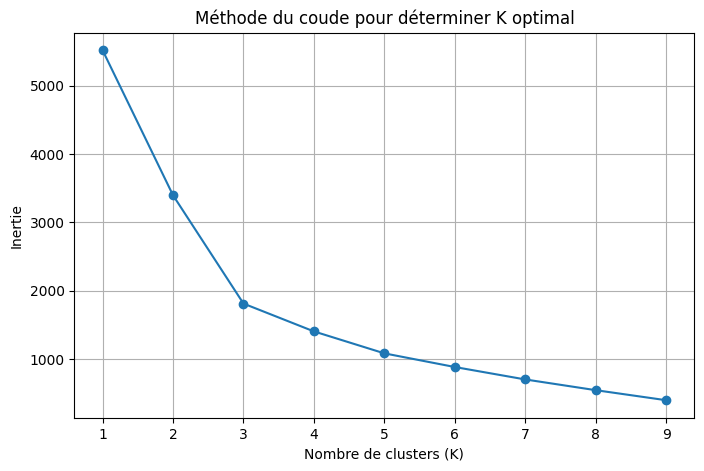

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour déterminer K optimal")
plt.grid()
plt.show()


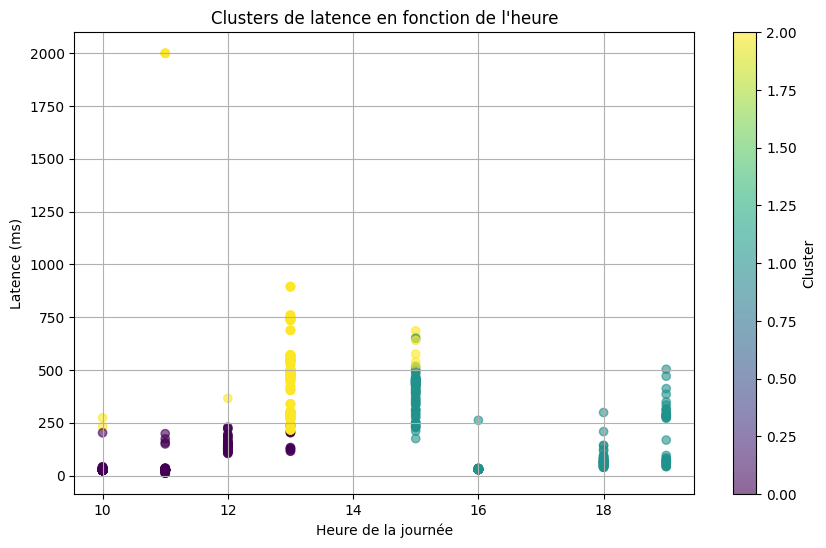

Centres des clusters :
[[4.41109932e+01 7.17400685e+00 1.05342466e+01 3.97945205e+00
  2.29109589e+00]
 [1.63995283e+02 3.99815472e+01 1.64867925e+01 3.16981132e-01
  3.61132075e+00]
 [4.73324784e+02 1.47047333e+02 1.29960784e+01 2.95294118e+00
  1.13725490e-01]]


In [17]:
# Application du clustering avec le K optimal (à définir en regardant le graphique)
K_OPTIMAL = 3  # Remplace par le nombre optimal trouvé
kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualisation des clusters (Latence vs Heure)
plt.figure(figsize=(10, 6))
plt.scatter(df['Heure'], df['Latence'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label="Cluster")
plt.xlabel("Heure de la journée")
plt.ylabel("Latence (ms)")
plt.title("Clusters de latence en fonction de l'heure")
plt.grid()
plt.show()

# Affichage des centres des clusters
print("Centres des clusters :")
print(scaler.inverse_transform(kmeans.cluster_centers_))

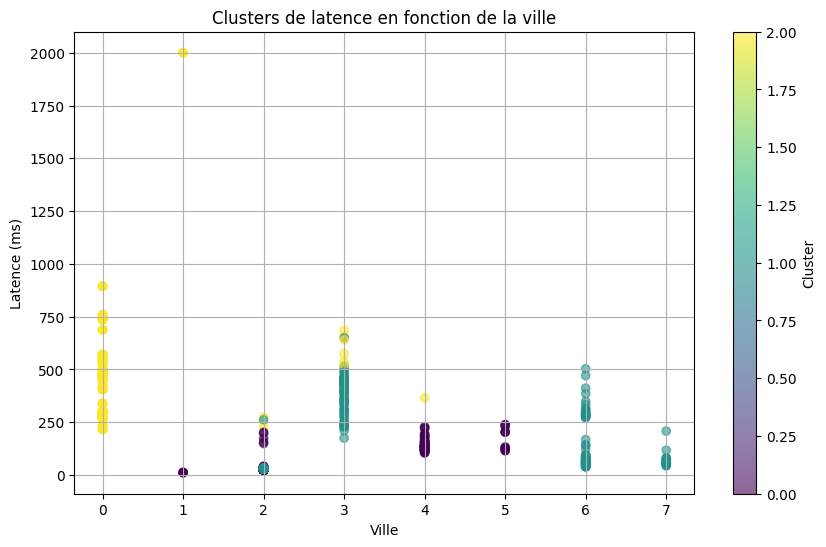

Centres des clusters :
[[4.41109932e+01 7.17400685e+00 1.05342466e+01 3.97945205e+00
  2.29109589e+00]
 [1.63995283e+02 3.99815472e+01 1.64867925e+01 3.16981132e-01
  3.61132075e+00]
 [4.73324784e+02 1.47047333e+02 1.29960784e+01 2.95294118e+00
  1.13725490e-01]]


In [19]:
# Application du clustering avec le K optimal (à définir en regardant le graphique)
K_OPTIMAL = 3  # Remplace par le nombre optimal trouvé
kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualisation des clusters (Latence vs Heure)
plt.figure(figsize=(10, 6))
plt.scatter(df['Ville_Code'], df['Latence'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(label="Cluster")
plt.xlabel("Ville")
plt.ylabel("Latence (ms)")
plt.title("Clusters de latence en fonction de la ville")
plt.grid()
plt.show()

# Affichage des centres des clusters
print("Centres des clusters :")
print(scaler.inverse_transform(kmeans.cluster_centers_))

**RandomForestRegressor**

In [7]:
# Sélection des features et de la variable cible
features = ['Jitter', 'Heure', 'Jour', 'Ville_Code', 'Throuput']
target = 'Latence'
df = df.dropna(subset=features + [target])

In [9]:
# Séparation des données en train et test
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Initialisation et entraînement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [12]:
# Prédiction sur les données de test
y_pred = model.predict(X_test_scaled)

In [13]:
# Évaluation du modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 8.91
Mean Squared Error (MSE): 286.69
R-squared (R2): 0.98


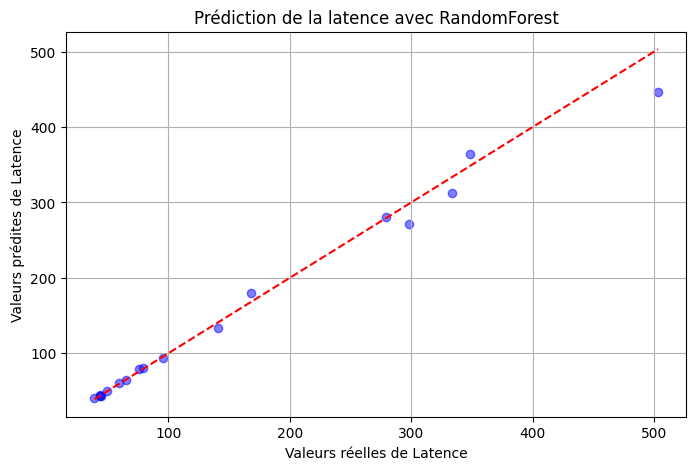

In [14]:
# Affichage des résultats
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
plt.xlabel("Valeurs réelles de Latence")
plt.ylabel("Valeurs prédites de Latence")
plt.title("Prédiction de la latence avec RandomForest")
plt.grid()
plt.show()